# Import danych

In [27]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
import random
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot
from sklearn.utils import shuffle
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

warnings.filterwarnings("ignore")

In [28]:
train_audio_path = '/content/drive/MyDrive/train/audio/'
model_path = '/content/drive/MyDrive/model/'


# Funkcje

## Wybór zbioru treningowego i walidacyjnego

In [30]:
def getTrainAndValidationSet(all_wave,y):
  return train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

## Metryki

In [45]:
def print_metrics(history,pred,original_labels,classes):
  plotDiagnosticChart(history)
  print_confusion_matrix(pred,original_labels,classes)
  print_classification_report(pred,original_labels,classes)

## Wykres diagnostczny

In [29]:
def plotDiagnosticChart(history):
  pyplot.plot(history.history['loss'], label='train')
  pyplot.plot(history.history['val_loss'], label='test')
  pyplot.legend()
  pyplot.show()

## Trening i testowaie na zbiorze walidacyjnym

In [31]:
def trainAndTest(model,x_tr,y_tr,x_val,y_val,es,mc):
  history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))
  return history

## Funkcję znajdująca wyraz odpowiadający sygnałowi audio

In [32]:
def predict(model,audio,classes):
    prob=model.predict(audio.reshape(-1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

## Raport klasyfikacji

In [33]:
def print_classification_report(pred,original_labels,classes):
  print(classification_report(original_labels, pred, labels=classes))

## Macierz pomyłek

In [34]:
  def print_confusion_matrix(pred,original_labels,classes):
    cf_matrix = confusion_matrix(original_labels, pred, labels=classes)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
              fmt='.2%', cmap='Blues',
              xticklabels=classes,
              yticklabels=classes)

# Wybór 5 słów i preprocessing

## Wylosowanie 5 słów

Losowo wybrane 5 słów

In [35]:
random_labels = os.listdir(train_audio_path)
print(random_labels)

['cat', 'one', 'up', 'three', 'left']


Ilość nagrań dla wybranych 5 słów

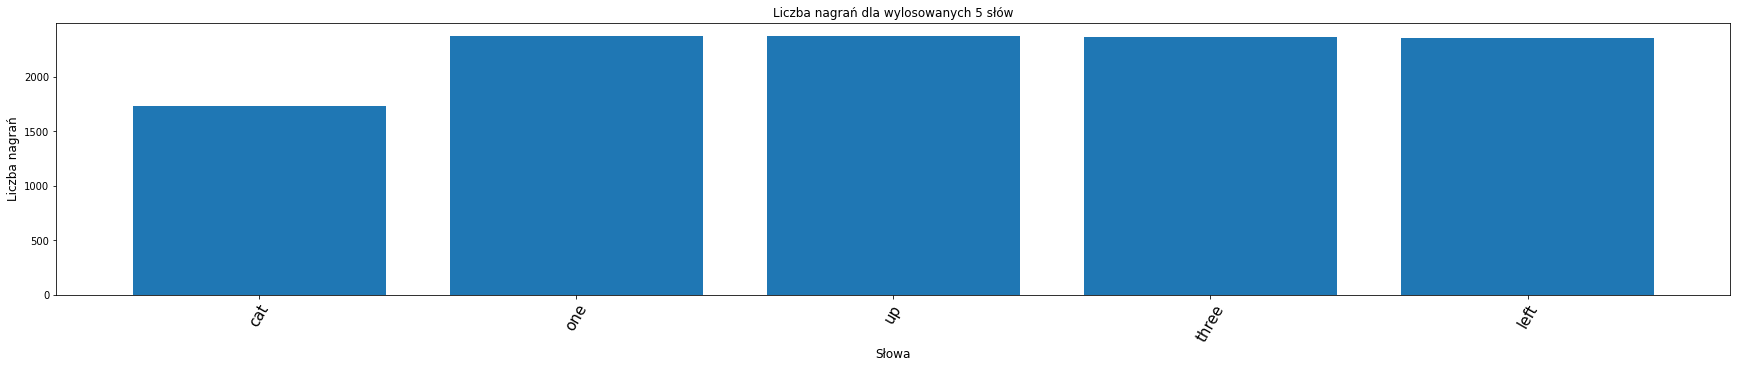

In [36]:
no_of_recordings=[]
for label in random_labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(random_labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Słowa', fontsize=12)
plt.ylabel('Liczba nagrań', fontsize=12)
plt.xticks(index, random_labels, fontsize=15, rotation=60)
plt.title('Liczba nagrań dla wylosowanych 5 słów')
plt.show()

## Preprocessing

Resampling nagrań o długości 1s do częstotliwości 8 tys HZ 

In [11]:
all_wave = []
all_label = []
for label in random_labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

cat


KeyboardInterrupt: ignored

In [37]:
%store -r all_wave
%store -r all_label

Konwersja etykiet tekstowych do kodów całkowitoliczbowych

In [38]:
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

 Konwersja całkowitoliczbowych etykiet do jednego wektora



In [39]:
y=np_utils.to_categorical(y, num_classes=len(random_labels))

# Sieć

Budowa modelu

In [40]:
def createModel():
  K.clear_session()
  inputs = Input(shape=(8000,1))

  #First Conv1D layer
  conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Third Conv1D layer
  conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Fourth Conv1D layer
  conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
  conv = MaxPooling1D(3)(conv)
  conv = Dropout(0.3)(conv)

  #Flatten layer
  conv = Flatten()(conv)

  #Dense Layer 1
  conv = Dense(256, activation='relu')(conv)
  conv = Dropout(0.3)(conv)

  #Dense Layer 2
  conv = Dense(128, activation='relu')(conv)
  conv = Dropout(0.3)(conv)

  outputs = Dense(len(random_labels), activation='softmax')(conv)

  model = Model(inputs, outputs)

  return model

# Zadanie 1

best_model500.hdf5
Rozmiar zbioru treningowego: 500
Epoch 1/100
13/13 [==============================] - 5s 272ms/step - loss: 1.6023 - accuracy: 0.2050 - val_loss: 1.6126 - val_accuracy: 0.1900

Epoch 00001: val_accuracy improved from -inf to 0.19000, saving model to /content/drive/MyDrive/model/best_model500.hdf5
Epoch 2/100
13/13 [==============================] - 3s 248ms/step - loss: 1.5652 - accuracy: 0.2958 - val_loss: 1.6179 - val_accuracy: 0.2100

Epoch 00002: val_accuracy improved from 0.19000 to 0.21000, saving model to /content/drive/MyDrive/model/best_model500.hdf5
Epoch 3/100
13/13 [==============================] - 3s 247ms/step - loss: 1.5123 - accuracy: 0.3035 - val_loss: 1.6163 - val_accuracy: 0.2000

Epoch 00003: val_accuracy did not improve from 0.21000
Epoch 4/100
13/13 [==============================] - 3s 247ms/step - loss: 1.4732 - accuracy: 0.3349 - val_loss: 1.5909 - val_accuracy: 0.2800

Epoch 00004: val_accuracy improved from 0.21000 to 0.28000, saving model

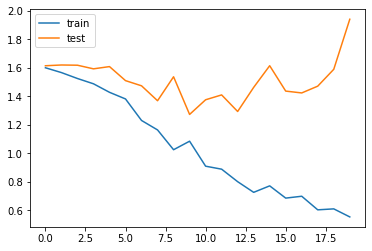

              precision    recall  f1-score   support

         cat       0.42      0.15      0.22       303
        left       0.66      0.77      0.71       433
         one       0.79      0.66      0.72       421
       three       0.80      0.76      0.78       430
          up       0.51      0.78      0.62       412

    accuracy                           0.65      1999
   macro avg       0.64      0.62      0.61      1999
weighted avg       0.65      0.65      0.63      1999

best_model800.hdf5
Rozmiar zbioru treningowego: 800
Epoch 1/100
20/20 [==============================] - 6s 267ms/step - loss: 1.6006 - accuracy: 0.2512 - val_loss: 1.6009 - val_accuracy: 0.2125

Epoch 00001: val_accuracy improved from -inf to 0.21250, saving model to /content/drive/MyDrive/model/best_model800.hdf5
Epoch 2/100
20/20 [==============================] - 5s 252ms/step - loss: 1.5526 - accuracy: 0.3438 - val_loss: 1.5875 - val_accuracy: 0.2688

Epoch 00002: val_accuracy improved from 0.21250 to

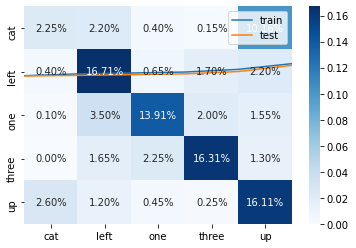

              precision    recall  f1-score   support

         cat       0.43      0.16      0.24       303
        left       0.68      0.75      0.71       433
         one       0.81      0.65      0.72       421
       three       0.77      0.87      0.82       430
          up       0.60      0.86      0.70       412

    accuracy                           0.69      1999
   macro avg       0.66      0.66      0.64      1999
weighted avg       0.67      0.69      0.66      1999

best_model1100.hdf5
Rozmiar zbioru treningowego: 1100
Epoch 1/100
28/28 [==============================] - 8s 261ms/step - loss: 1.6074 - accuracy: 0.2494 - val_loss: 1.5999 - val_accuracy: 0.2545

Epoch 00001: val_accuracy improved from -inf to 0.25455, saving model to /content/drive/MyDrive/model/best_model1100.hdf5
Epoch 2/100
28/28 [==============================] - 7s 253ms/step - loss: 1.5650 - accuracy: 0.2929 - val_loss: 1.5789 - val_accuracy: 0.2864

Epoch 00002: val_accuracy improved from 0.25455

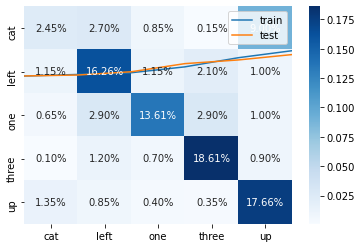

              precision    recall  f1-score   support

         cat       0.86      0.57      0.68       303
        left       0.78      0.77      0.77       433
         one       0.84      0.74      0.79       421
       three       0.86      0.91      0.88       430
          up       0.68      0.90      0.77       412

    accuracy                           0.79      1999
   macro avg       0.80      0.78      0.78      1999
weighted avg       0.80      0.79      0.79      1999

best_model1400.hdf5
Rozmiar zbioru treningowego: 1400
Epoch 1/100
35/35 [==============================] - 10s 258ms/step - loss: 1.6011 - accuracy: 0.2327 - val_loss: 1.6003 - val_accuracy: 0.2357

Epoch 00001: val_accuracy improved from -inf to 0.23571, saving model to /content/drive/MyDrive/model/best_model1400.hdf5
Epoch 2/100
35/35 [==============================] - 9s 251ms/step - loss: 1.5622 - accuracy: 0.3191 - val_loss: 1.5192 - val_accuracy: 0.3250

Epoch 00002: val_accuracy improved from 0.2357

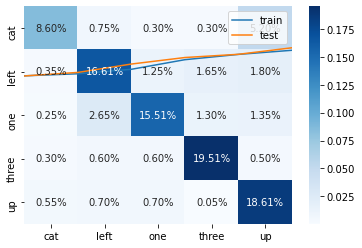

              precision    recall  f1-score   support

         cat       0.52      0.53      0.52       303
        left       0.74      0.79      0.77       433
         one       0.88      0.70      0.78       421
       three       0.81      0.90      0.86       430
          up       0.74      0.74      0.74       412

    accuracy                           0.75      1999
   macro avg       0.74      0.73      0.73      1999
weighted avg       0.75      0.75      0.75      1999

best_model1700.hdf5
Rozmiar zbioru treningowego: 1700
Epoch 1/100
43/43 [==============================] - 12s 254ms/step - loss: 1.6013 - accuracy: 0.2359 - val_loss: 1.5853 - val_accuracy: 0.2706

Epoch 00001: val_accuracy improved from -inf to 0.27059, saving model to /content/drive/MyDrive/model/best_model1700.hdf5
Epoch 2/100
43/43 [==============================] - 11s 250ms/step - loss: 1.5857 - accuracy: 0.2787 - val_loss: 1.5559 - val_accuracy: 0.3147

Epoch 00002: val_accuracy improved from 0.270

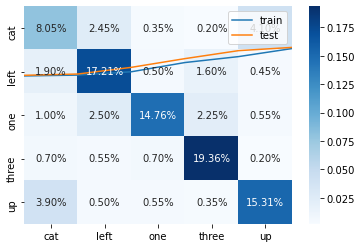

              precision    recall  f1-score   support

         cat       0.66      0.50      0.57       303
        left       0.80      0.76      0.78       433
         one       0.85      0.82      0.84       421
       three       0.86      0.91      0.88       430
          up       0.74      0.89      0.81       412

    accuracy                           0.79      1999
   macro avg       0.78      0.78      0.78      1999
weighted avg       0.79      0.79      0.79      1999

best_model2000.hdf5
Rozmiar zbioru treningowego: 2000
Epoch 1/100
50/50 [==============================] - 14s 261ms/step - loss: 1.5961 - accuracy: 0.2475 - val_loss: 1.5483 - val_accuracy: 0.3250

Epoch 00001: val_accuracy improved from -inf to 0.32500, saving model to /content/drive/MyDrive/model/best_model2000.hdf5
Epoch 2/100
50/50 [==============================] - 13s 254ms/step - loss: 1.4820 - accuracy: 0.3421 - val_loss: 1.3160 - val_accuracy: 0.4400

Epoch 00002: val_accuracy improved from 0.325

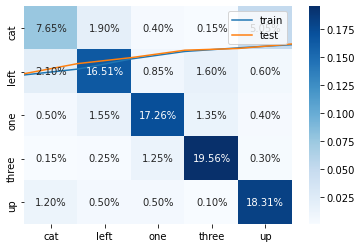

              precision    recall  f1-score   support

         cat       0.78      0.51      0.62       303
        left       0.71      0.86      0.78       433
         one       0.84      0.78      0.81       421
       three       0.89      0.88      0.88       430
          up       0.79      0.86      0.82       412

    accuracy                           0.80      1999
   macro avg       0.80      0.78      0.78      1999
weighted avg       0.80      0.80      0.79      1999



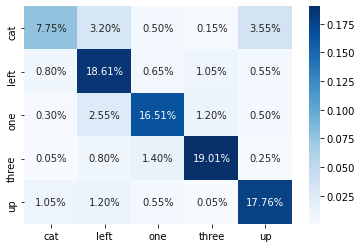

In [46]:
all_wave = np.array(all_wave)
X_tr, X_test, Y_tr, Y_test = train_test_split(all_wave, y,stratify=y,test_size = 0.2,random_state=666,shuffle=True)

for size in range(500,2300,300):
  model = createModel()
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
  print(f"best_model{size}.hdf5") 
  mc = ModelCheckpoint(f"{model_path}best_model{size}.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  print('Rozmiar zbioru treningowego: ' + str(size))
  wav = X_tr[:size,:]
  new_y = Y_tr[:size,:]
  wav = np.array(wav).reshape(-1,8000,1)

  x_tr, x_val, y_tr, y_val = getTrainAndValidationSet(wav,new_y)
  history = trainAndTest(model,x_tr,y_tr,x_val,y_val,es,mc)

  model=load_model(f"{model_path}best_model{size}.hdf5")
  pred = [predict(model, sample, classes) for sample in X_test]
  original_labels = [classes[np.argmax(label)] for label in Y_test]

  print_metrics(history,pred,original_labels,classes)
  

  

